In [8]:
# Important: Code is mostly re-used from https://github.com/moduIo/Deep-Q-network/blob/master/DQN.ipynb
# Code may change with more clean-ups and explanation
import gym
from collections import deque

# Agent

In [9]:
from dqn_agent import DQN_Agent

# Preprocessing

In [11]:
from utils import blend_images, process_frame

# Environment

In [12]:
env = gym.make('Breakout-v4', render_mode="rgb_array")
state_size = (105, 80, 1)
action_size = env.action_space.n
minimum_memory_size = 1000 # Minimum experience replay memory size before training
max_memory_size = 10000 # Maximum experience replay memory
agent = DQN_Agent(state_size, action_size, memory_size=max_memory_size)

episodes = 50
batch_size = 64
skip_start = 90  # Breakout-v0 waits for 90 actions before the episode begins
total_time = 0   # Counter for total number of steps taken
all_rewards = 0  # Used to compute avg reward over time
blend = 4        # Number of images to blend
done = False

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 20, 32)        2080      
                                                                 
 activation (Activation)     (None, 27, 20, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 10, 64)        32832     
                                                                 
 activation_1 (Activation)   (None, 14, 10, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 10, 64)        36928     
                                                                 
 activation_2 (Activation)   (None, 14, 10, 64)        0         
                                                                 
 flatten (Flatten)           (None, 8960)              0

In [13]:
## Create tensorboard logs (plots)
import datetime
import tensorflow.summary as summary_writer
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M")
train_log_dir = './logs/' + current_time + '/train'
train_summary_writer = summary_writer.create_file_writer(train_log_dir)

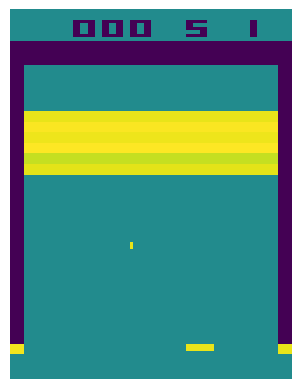

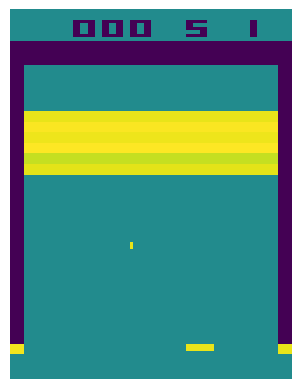

In [17]:

## Visualize state
observation = env.reset()
observation = env.step(1)
for skip in range(2): # skip the start of each game/
    observation = env.step(0)

# observation = observation[100::]
processed_observation = process_frame(observation[0])

from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
def show_state(state, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(state)
    # plt.title("Step: %d %s" % (step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

show_state(processed_observation[0])

In [ ]:
import numpy as np
cropped_obs = processed_observation[0][25:,:]
# cropped_obs = np.expand_dims(cropped_obs.reshape(105, 80, 1), axis=0)
# show_state(cropped_obs)

In [ ]:
blend = 4
max_steps_per_episode = 2000
for e in range(episodes):
    total_reward = 0
    game_score = 0
    observation = env.reset()
    # print(observation)
    state = process_frame(observation[0])
    images = deque(maxlen=blend)  # Array of images to be blended
    images.append(state)
    
    for skip in range(skip_start): # skip the start of each game
        env.step(0)
    
    # generate an episode
    for time in range(max_steps_per_episode):
        total_time += 1
        
        # Every update_rate timesteps we update the target network parameters
        if total_time % agent.update_rate == 0:
            # Update the target model by copying weights from Qnetwork
            agent.update_target_model()
        
        # Return the avg of the last 4 frames
        state = blend_images(images, state_size, blend)
        
        # Choose and apply action
        action = agent.act(state)
        next_observation, reward, done, _, _ = env.step(action)
        
        # TODO: Process the frame and save it to memory
        # 1. pre-process the image (grayscale conversion, crop, resize...)
        processed_state = process_frame(next_observation)
        # 2. Combine with previous images in the image circular buffer (size=4)
        images.append(processed_state)
        next_state = blend_images(images, state_size, blend)
        # 3. Add to the replay memory
        agent.remember(state, action, reward, next_state, done)
        
        # Update state, and rewards
        state = next_state
        game_score += reward
        total_reward += reward
        
        if done:
            all_rewards += game_score
            
            print("episode: {}/{}, game score: {}, reward: {}, avg reward: {}, time: {}, total time: {}"
                  .format(e+1, episodes, game_score, total_reward, all_rewards/(e+1), time, total_time))   
            break

        if len(agent.memory) > minimum_memory_size and (total_time % 500) == 0:
            # train
            agent.replay(batch_size)

    with train_summary_writer.as_default():       
        summary_writer.scalar('game_score', game_score, step=e)
    # TODO: Save model every n (try 10 or 25) episodes
    if e % 10 == 0:
        fname = f'models/{max_memory_size}-memory_{e}-games'
        agent.save(fname)



In [ ]:
# agent.save('models/5k-memory_100-games')

In [ ]:
import time
!pip install IPython
!pip install matplotlib
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render())
    plt.title("Step: %d %s" % (step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

game_score = 0
total_reward = 0
done = False
reward = 0
env.reset()
images = deque(maxlen=blend)
for t in range(2000):
    for skip in range(skip_start): # skip the start of each game
        env.step(0)
    show_state(env, t)
    total_time += 1
    
    # Return the avg of the last 4 frames
    state = blend_images(images, state_size, blend)
    
    # Transition Dynamics
    action = agent.greedy_act(state)
    next_state, reward, done, _, _ = env.step(action)
    
    # Return the avg of the last 4 frames
    next_state = process_frame(next_state)
    images.append(next_state)
    next_state = blend_images(images, state_size, blend)
        
    state = next_state
    game_score += reward
    reward -= 1  # Punish behavior which does not accumulate reward
    total_reward += reward
    time.sleep(0.05)
    if done:
        all_rewards += game_score
        
        print("game score: {}, reward: {}"
                .format(game_score, total_reward))
        
        break